In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorboard.plugins.hparams import api as hp

from keras import activations
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy
from keras.models import Model

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

In [21]:
np.random.seed(0)

tf.config.optimizer.set_jit(True)
scaler = StandardScaler()

### Conjunto de datos: SDSS DR17

In [22]:
data = pd.read_csv('./SDSS/star_classification.csv')
cols = ['alpha','delta','u','g','r','i','z','redshift','class']
data = data[cols]
data.head()

,alpha,delta,u,g,r,i,z,redshift,class
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY


Se cambian las clases a vectores con números enteros

$$ \text{GALAXY}: \begin{pmatrix}1\\0\\0\end{pmatrix},\quad \text{STAR}: \begin{pmatrix}0\\1\\0\end{pmatrix},\quad \text{QSO}:\begin{pmatrix}0\\0\\1\end{pmatrix} $$

In [23]:
data["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in data["class"]]
print(data.head())
data = data.to_numpy()

        alpha      delta         u         g         r         i         z  \
0  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827   
3  338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454  19.25010   
4  345.282593  21.183866  19.43718  17.58028  16.49747  15.97711  15.54461   

   redshift  class  
0  0.634794      0  
1  0.779136      0  
2  0.644195      0  
3  0.932346      0  
4  0.116123      0  


### Implementación

Se establecen las funciones necesarias para aplicar el algorítmo genético a partir de lo siguiente

- 1) Decodificar el gen del individuo para obtener el núm. de capas ocultas, núm. de neuronas y la tasa de aprendizaje.
    
    
- 2) Preparar el conjunto de datos para dividirlos en conjunto de entrenamiento y validación.
    
    
- 3) Entrenar la red neuronal, calcular la presición del modelo en el conjunto de validación y regresarlo como fitness score para el algorítmo genético.

In [41]:
# Activation function layers

f1 = lambda x: Dense(x, activation='relu')      #ReLU
f2 = lambda x: keras.layers.LeakyReLU(0.3)   #LReLU
f3 = lambda x: Dense(x, activation='elu')       #ELU
f4 = lambda x: Dense(x, kernel_initializer='lecun_normal', activation='selu')   #SELU

f_names = ["ReLU", "LReLU", "ELU", "SELU"]

In [72]:
SC_DEEP       = np.array([2,4,8,16,24,32,48,64])             # Number of deep layers (8)
SC_NUM_UNITS  = np.array([16,32,64,96,128,256,384,512])    # Number of fully conected neurons (8)
SC_LEARNING   = np.array([1e-4,1e-3,1e-2,1e-1])              # Learning rates (4)
SC_ACTIVATION = [f1, f2, f3, f4]                             # Activation function layers (4)
# SC_BATCHSIZE = np.array([16,32])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max',
                               min_delta=0,
                               patience=6,
                               restore_best_weights=True)]
    
batch_size = 128;      epochs = 30

In [73]:
# Divide data into X and Y and implement hot_ones in Y
def prepare_dataset(data):
    X, Y = np.empty((0)), np.empty((0))
    X = data[:,0:8]
    Y = data[:,8]
    Y = to_categorical(Y, num_classes=3)
    return X, Y

In [74]:
# Split dataset into train and validation (70/30)
X,Y = prepare_dataset(data)
X_train, X_test, Y_train, Y_test = split(X, Y, test_size = 0.3, random_state = 0)
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [88]:
def train_evaluate(ga_individual_solution):   
    t = time.time(); t_total = 0
    
    # Decode GA solution to integer for window_size and num_units
    deep_layers_bits   = BitArray(ga_individual_solution[0:3])   # (8)
    num_units_bits     = BitArray(ga_individual_solution[3:6])   # (8)
    learning_rate_bits = BitArray(ga_individual_solution[6:8])   # (4)
    activation_f_bits  = BitArray(ga_individual_solution[8:10])  # (4)
    
    deep_layers   = SC_DEEP[deep_layers_bits.uint]
    num_units     = SC_NUM_UNITS[num_units_bits.uint]
    learning_rate = SC_LEARNING[learning_rate_bits.uint]
    activation_f  = SC_ACTIVATION[activation_f_bits.uint]
    
    print('\n--- Starting trial:', len(datos)+1 )
    print('Deep Layers: ',deep_layers,', Number of neurons: ',num_units,", Learning rate: ",learning_rate,', Activation function: ',f_names[activation_f_bits.uint])
    
    # Train model and predict on validation set
    model = keras.Sequential()
    model.add(Input(shape=(int(X_train.shape[1]),)))
    model.add(Dense(num_units, input_shape=(int(X_train.shape[1]),)))
    
    for i in range(deep_layers):        
        model.add(activation_f(num_units))
        if i % SC_NUM_UNITS[1]==0:
            model.add(keras.layers.Dropout(0.3))
    model.add(Dense(3, activation=tf.nn.softmax))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=["categorical_accuracy"])
    model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test),
              callbacks=callbacks, batch_size=batch_size, shuffle=True, verbose=0)
    
    _, score = model.evaluate(X_test, Y_test)    
    t = time.time()-t
    print("Accuracy:", score, ", Elapsed time:", t)

    datos.append([deep_layers, num_units, learning_rate, f_names[activation_f_bits.uint], score, t])
    
    return score,

A continuación, use la paquetería DEAP para definir las cosas para ejecutar GA. Usaremos una representación binaria para la solución de longitud diez. Se inicializará aleatoriamente utilizando la distribución de Bernoulli. Del mismo modo, se utiliza el crossover ordenado, la mutación aleatoria y la selección de la rueda de la ruleta. Los valores del parámetro GA se inicializan arbitrariamente.

In [89]:
population_size = 2
num_generations = 5
gene_length = 10

datos = []

# set the random seed:
toolbox = base.Toolbox()

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = [1.0])
creator.create('Individual', list , fitness = creator.FitnessMax)

# create the individual operator to fill up an Individual instance:
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)

# create the population operator to generate a list of individuals:
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

# Eggholder function as the given individual's fitness:
toolbox.register("evaluate", score)

# genetic operators:
toolbox.register('select', tools.selRoulette)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.5, mutpb = 0.2, 
                        ngen = num_generations, verbose = 1)

C:\Users\Joshu\.conda\envs\tensorflow\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Joshu\.conda\envs\tensorflow\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



--- Starting trial: 1
Deep Layers:  8 , Number of neurons:  64 , Learning rate:  0.0001 , Activation function:  LReLU
30000/30000 [==============================] - 4s 134us/sample - loss: 0.7766 - categorical_accuracy: 0.7121
Accuracy: 0.7121 , Elapsed time: 12.039982318878174

--- Starting trial: 2
Deep Layers:  64 , Number of neurons:  256 , Learning rate:  0.0001 , Activation function:  LReLU
30000/30000 [==============================] - 10s 330us/sample - loss: 0.6251 - categorical_accuracy: 0.7859
Accuracy: 0.7859 , Elapsed time: 40.09395170211792
gen	nevals
0  	2     
1  	0     
2  	0     

--- Starting trial: 3
Deep Layers:  8 , Number of neurons:  64 , Learning rate:  0.0001 , Activation function:  LReLU
30000/30000 [==============================] - 4s 130us/sample - loss: 0.7720 - categorical_accuracy: 0.7236
Accuracy: 0.72363335 , Elapsed time: 12.611989736557007

--- Starting trial: 4
Deep Layers:  8 , Number of neurons:  64 , Learning rate:  0.0001 , Activation function

### Guardar datos

In [92]:
filename = "historial_sdss.txt"
df = pd.DataFrame(datos, columns = ["Deep size", "Num units", "Learning rate", "Activation function", "Accuracy", "Elapsed time"])

df.sort_values(by=["Accuracy", "Elapsed time"], ascending=[0,0], ignore_index=True, inplace=True)

df.to_csv(filename, header=True, index=False, sep='\t', mode='w') # a=append, w=overwrite

In [93]:
df

,Deep size,Num units,Learning rate,Activation function,Accuracy,Elapsed time
0,64,256,0.0001,LReLU,0.785900,40.093952
1,8,64,0.0001,LReLU,0.743933,11.341249
2,8,64,0.0001,LReLU,0.737667,11.378333
3,8,64,0.0001,LReLU,0.731433,11.826807
4,8,64,0.0001,LReLU,0.723633,12.611990
5,8,64,0.0001,LReLU,0.712100,12.039982
6,32,16,0.0001,LReLU,0.676500,14.907283


In [12]:
np.sum(df[["Tiempo de ejecución"]])/60/60

Tiempo de ejecución    1.728621
dtype: float64

### Cargar datos

In [13]:
pathname = os.path.join('.\\', filename)
while True:
    try: 
        df 
        break
    except:
        df = pd.read_csv(pathname, delimiter = "\t")
        break

In [14]:
df

,Deep size,Num units,Learning rate,Accuracy,Tiempo de ejecución
0,20,40,0.0008,0.970867,153.535004
1,20,25,0.0008,0.970633,162.363049
2,35,25,0.0024,0.970167,233.924334
3,10,30,0.0012,0.969633,110.836161
4,20,40,0.0008,0.969567,145.803060
5,10,25,0.0020,0.969267,96.513949
6,10,30,0.0016,0.969233,93.951861
7,5,30,0.0012,0.968733,73.867024
8,20,35,0.0008,0.968433,170.746890
9,10,20,0.0008,0.968233,87.122006


### Mejores individuos

In [105]:
# Selecciona los mejores k individuos - (para k=5)
k = 10
best_genes = df.iloc[:k,]

best_deep_size = best_genes.iloc[:,0]
best_num_units = best_genes.iloc[:,1]
best_learning_rate = best_genes.iloc[:,2]

best_genes

,Deep size,Num units,Learning rate,Accuracy,Tiempo de ejecución
0,20,40,0.0008,0.970867,153.535004
1,20,25,0.0008,0.970633,162.363049
2,35,25,0.0024,0.970167,233.924334
3,10,30,0.0012,0.969633,110.836161
4,20,40,0.0008,0.969567,145.803060
5,10,25,0.0020,0.969267,96.513949
6,10,30,0.0016,0.969233,93.951861
7,5,30,0.0012,0.968733,73.867024
8,20,35,0.0008,0.968433,170.746890
9,10,20,0.0008,0.968233,87.122006


In [20]:
best_deep_size

0    20
1    20
2    35
3    10
4    20
Name: Deep size, dtype: int64

In [28]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set

X,Y = prepare_dataset(data)
X_train, X_test, Y_train, Y_test = split(X, Y, test_size = 0.20, random_state = 0)

models = []
historial = []
y_pred = []

for k in range(len(best_deep_size)):
    print('\n--- Starting trial:', k)
    print('Deep Size: ', best_deep_size[k], ', Num of Units: ', best_num_units[k], ', Learning rate: ', best_learning_rate[k])
    
    models.append(keras.Sequential())
    models[-1].add(Input(shape=(int(X_train.shape[1]),)))
    models[-1].add(Dense(best_num_units[k], input_shape=(int(X_train.shape[1]),)))
#     x = LSTM(num_units, input_shape=(window_size,1))(inputs)

    for i in range(best_deep_size[k]):        
        models[-1].add(Dense(best_num_units[k], activation='relu'))
    models[-1].add(Dense(3, activation=tf.nn.softmax))

    optimizer = keras.optimizers.Adam(learning_rate=best_learning_rate[k], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    models[-1].compile(
            optimizer=optimizer,
            loss=CategoricalCrossentropy(),
            metrics=["categorical_accuracy"])
            
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                       min_delta=0,
                                       patience=50,
                                       restore_best_weights=True)]
#     history = models[-1].fit(X_train, y_train, validation_data=(X_test, y_test), 
#                         epochs=best_epochs, callbacks=callbacks, batch_size=best_batch_size, shuffle=True)
    historial.append(models[-1].fit(X_train, y_train, epochs=20, validation_data=(X_test, Y_test),
                                    batch_size=128, shuffle=True))
    y_pred.append(models[-1].predict(X))
    
    _, score = models[-1].evaluate(X_test, Y_test)  

    print('Test score: ', score)


--- Starting trial: 0
Deep Size:  20 , Num of Units:  40 , Learning rate:  0.0008
Train on 80000 samples, validate on 20000 samples
Epoch 1/20
80000/80000 [==============================] - 17s 215us/sample - loss: 0.9501 - categorical_accuracy: 0.5922 - val_loss: 0.9419 - val_categorical_accuracy: 0.5925
Epoch 2/20
80000/80000 [==============================] - 10s 124us/sample - loss: 0.6575 - categorical_accuracy: 0.7178 - val_loss: 0.5942 - val_categorical_accuracy: 0.7368
Epoch 3/20
80000/80000 [==============================] - 10s 126us/sample - loss: 0.5502 - categorical_accuracy: 0.7659 - val_loss: 0.5578 - val_categorical_accuracy: 0.7521
Epoch 4/20
80000/80000 [==============================] - 10s 129us/sample - loss: 0.5114 - categorical_accuracy: 0.7856 - val_loss: 0.5584 - val_categorical_accuracy: 0.7725
Epoch 5/20
80000/80000 [==============================] - 10s 129us/sample - loss: 0.4350 - categorical_accuracy: 0.8206 - val_loss: 0.3202 - val_categorical_accuracy:

Epoch 7/20
80000/80000 [==============================] - 10s 120us/sample - loss: 0.2601 - categorical_accuracy: 0.9028 - val_loss: 0.2273 - val_categorical_accuracy: 0.9154
Epoch 8/20
80000/80000 [==============================] - 9s 109us/sample - loss: 0.2249 - categorical_accuracy: 0.9194 - val_loss: 0.1841 - val_categorical_accuracy: 0.9327
Epoch 9/20
80000/80000 [==============================] - 9s 108us/sample - loss: 0.2096 - categorical_accuracy: 0.9259 - val_loss: 0.1735 - val_categorical_accuracy: 0.9410
Epoch 10/20
80000/80000 [==============================] - 10s 124us/sample - loss: 0.2261 - categorical_accuracy: 0.9176 - val_loss: 0.2017 - val_categorical_accuracy: 0.9307
Epoch 11/20
80000/80000 [==============================] - 9s 118us/sample - loss: 0.2096 - categorical_accuracy: 0.9258 - val_loss: 0.1907 - val_categorical_accuracy: 0.9295
Epoch 12/20
80000/80000 [==============================] - 9s 110us/sample - loss: 0.2112 - categorical_accuracy: 0.9254 - val

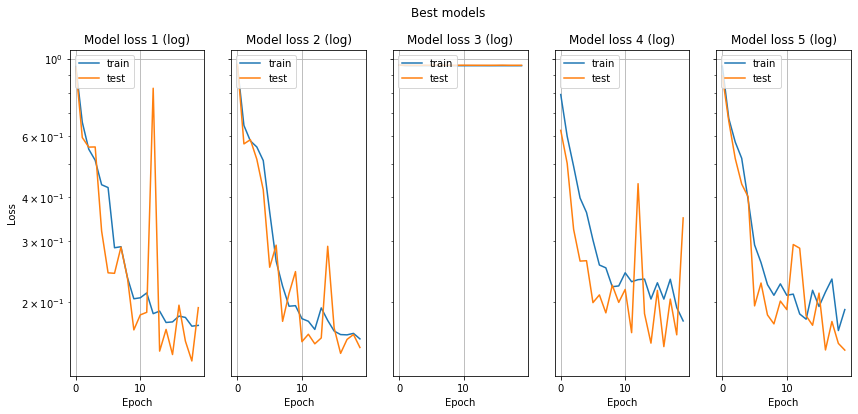

In [31]:
fig, axs = plt.subplots(1, 5, figsize=(14,6), sharey='row')
fig.suptitle('Best models')
titles = []
for k in range(len(models)):
    titles.append(f"Model loss {k+1} (log)")
    axs[k].plot(historial[k].history['loss'])
    axs[k].plot(historial[k].history['val_loss'])
#     print(titles[-1])
    axs[k].set_title(titles[-1])
    axs[k].set_yscale("log")
    axs[k].legend(['train', 'test'], loc='upper left')
    axs[k].grid()

for ax in axs.flat:
#     ax.set(xlabel='Epoch', ylabel='Loss')
    ax.set(xlabel='Epoch')
axs.flat[0].set(ylabel='Loss')
plt.show()

### Gráficas de comparación

In [37]:
Y_pred1 = np.argmax(models[0].predict(X), axis=1)
Y_pred2 = np.argmax(models[1].predict(X), axis=1)
# Y_pred3 = np.argmax(models[2].predict(X), axis=1)

In [38]:
Y_pred1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [74]:
# X[:,4].min(),X[:,4].max(), X[:,4].mean(), X[:,4].std()

(9.82207, 29.571859999999997, 19.645762146, 1.854750420523872)

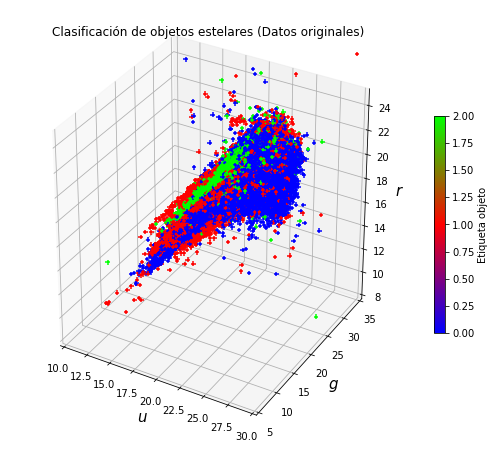

In [95]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,2], X[:,3], X[:,4], marker='+', c=np.argmax(Y,axis=1), cmap='brg', alpha=1)
ax.set_xlabel('$u$', fontsize=15); ax.set_xlim([10, 30])
ax.set_ylabel('$g$', fontsize=15); ax.set_ylim([5, 35])
ax.set_zlabel('$r$', fontsize=15); ax.set_zlim([8, 25])
plt.colorbar(p, shrink=0.5, label='Etiqueta objeto'); plt.title(r"Clasificación de objetos estelares (Datos originales)")
plt.show()

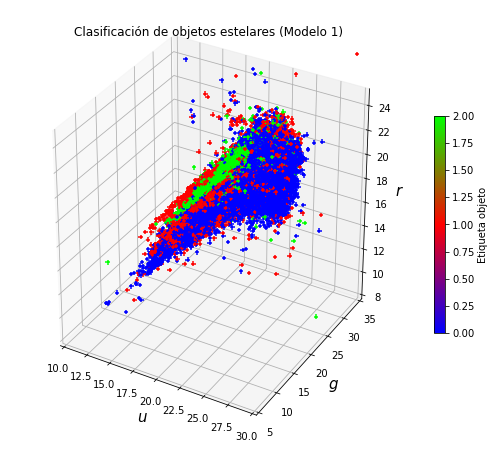

In [96]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,2], X[:,3], X[:,4], marker='+', c=Y_pred1, cmap='brg', alpha=1)
ax.set_xlabel('$u$', fontsize=15); ax.set_xlim([10, 30])
ax.set_ylabel('$g$', fontsize=15); ax.set_ylim([5, 35])
ax.set_zlabel('$r$', fontsize=15); ax.set_zlim([8, 25])
plt.colorbar(p, shrink=0.5, label='Etiqueta objeto'); plt.title(r"Clasificación de objetos estelares (Modelo 1)")
plt.show()

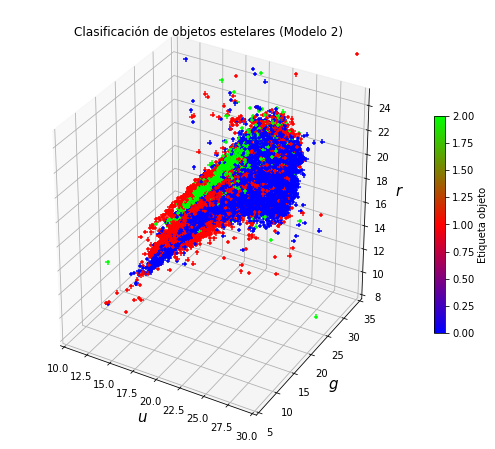

In [97]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,2], X[:,3], X[:,4], marker='+', c=Y_pred2, cmap='brg', alpha=1)
ax.set_xlabel('$u$', fontsize=15); ax.set_xlim([10, 30])
ax.set_ylabel('$g$', fontsize=15); ax.set_ylim([5, 35])
ax.set_zlabel('$r$', fontsize=15); ax.set_zlim([8, 25])
plt.colorbar(p, shrink=0.5, label='Etiqueta objeto'); plt.title(r"Clasificación de objetos estelares (Modelo 2)")
plt.show()

### Resultado de hiperparámetros

In [98]:
import seaborn as sns

In [108]:
best_genes.mean()

Deep size               16.000000
Num units               30.000000
Learning rate            0.001240
Accuracy                 0.969477
Tiempo de ejecución    132.866334
dtype: float64

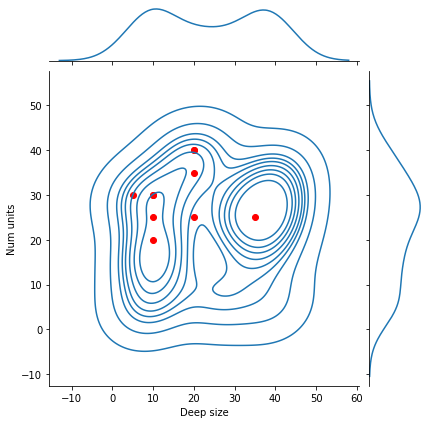

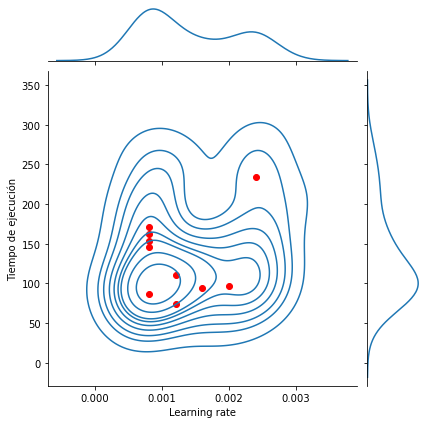

In [107]:
g1= sns.jointplot(data=df, x="Deep size", y="Num units", kind="kde")
g1.ax_joint.scatter(best_genes.iloc[:,0], best_genes.iloc[:,1], color = 'red', label="a")

plt.show()

g2= sns.jointplot(x=df.iloc[:,2], y=df.iloc[:,4], kind='kde')
g2.ax_joint.scatter(best_genes.iloc[:,2], best_genes.iloc[:,4], color = 'red', label="a")

plt.show()

In [ ]:
# Guarda las mejores N soluciones - (1, para k=1)
# best_individuals2 = tools.selBest(population,k = 20)
# deep_size2 = []
# num_units2 = []
# learning_rate2 = []
# batch_size2 = []
# epochs2 = []
# t = 0

# for bi in best_individuals2:
#     deep_size_bits2 = BitArray(bi[0:2])
#     num_units_bits2 = BitArray(bi[2:4])
#     learning_rate_bits2 = BitArray(bi[4:7])
#     batch_size_bits2 = BitArray(bi[7:9])
#     epochs_bits2 = BitArray(bi[9:])
#     t += 1 
    
#     deep_size2.append( 4*(deep_size_bits2.uint + 1))
#     num_units2.append( 4*(num_units_bits2.uint + 1))
#     learning_rate2.append( 8*(learning_rate_bits2.uint+1)*10**(-4))
#     batch_size2.append( 2**(batch_size_bits2.uint +1))
#     epochs2.append( 50*(epochs_bits2.uint +1))
#     print('k=',t,'\nDeep Size: ', best_deep_size2[-1], ', Num of Units: ', best_num_units2[-1], ', Learning rate: ', best_learning_rate2[-1])
#     print('Batch Size: ', best_batch_size2[-1], ", Num of Epochs: ", best_epochs2[-1])

In [ ]:
# fig, axs = plt.subplots(1,2, figsize=(15,5))

# fig.suptitle('Última generación de hipermarámetros obtenidos')

# # axs[0].plot(df.iloc[:,0], df.iloc[:,1], alpha=0.5, c='blue', label="Model pred 1")
# axs[0].scatter(df.iloc[:,0], df.iloc[:,1], s=20, alpha=0.3, c='red', label="Model pred 1")
# axs[0].scatter(best_genes.iloc[:,0], best_genes.iloc[:,1], s=80, alpha=1, c='red', label="Mejores individuos")
# axs[0].grid(); axs[0].legend()
# # axs[0].legend(loc='upper right'); 
# # axs[0].set_xlim([2, 18]); axs[0].set_ylim([1, 65])
# axs[0].set(xlabel=r'Deep size', ylabel='Num units')

# # axs[1].plot(df.iloc[:,2], df.iloc[:,3], alpha=0.5, c='blue', label="Model pred 1")
# axs[1].scatter(df.iloc[:,2], df.iloc[:,3], s=20, alpha=0.3, c='red', label="Model pred 1")
# axs[1].scatter(best_genes.iloc[:,2], best_genes.iloc[:,3], s=80, alpha=1, c='red', label="Mejores individuos")
# axs[1].set_yscale("log"); 
# axs[1].grid(); axs[1].legend(loc='upper right')
# # axs[1].set_xlim([1e-4, 31e-4]); axs[1].set_ylim([2**1, 2**4])
# axs[1].set(xlabel=r'Learning rate', ylabel='Batch size')